In [1]:
import tensorflow as tf
import keras, keras.layers as L, keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from keras.models import save_model
import keras
from keras.datasets import cifar10, fashion_mnist
from keras.models import load_model
from keras.callbacks import TensorBoard
from annoy import AnnoyIndex

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import UpSampling2D, Reshape, Dense,Activation, Flatten, Dropout, BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, InputLayer
from keras import regularizers
from keras.callbacks import LearningRateScheduler

%matplotlib inline

Using TensorFlow backend.


In [3]:
class ModelSaveCallback(keras.callbacks.Callback):

    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))


# !!! remember to clear session/graph if you rebuild your graph to avoid out-of-memory errors !!!
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)

In [4]:
reset_tf_session()

In [5]:
bit_size = 32
architecture = '1024'
autoencoder_id='03'
model_path = F'fashion-models/bitsize{bit_size}/{architecture}architecture/'

In [6]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [7]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (60000, 28, 28) (60000,)
Test samples: (10000, 28, 28) (10000,)


In [8]:
x_train = x_train.reshape([-1, 28, 28, 1])
x_test = x_test.reshape([-1, 28, 28, 1])

IMG_SHAPE = x_train.shape[1:]

# center images
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [9]:
model_path

'fashion-models/bitsize32/1024architecture/'

In [10]:
autoencoder = load_model(F'{model_path}autoencoder{autoencoder_id}.h5')
encoder = load_model(F'{model_path}encoder{autoencoder_id}.h5')
decoder = load_model(F'{model_path}decoder{autoencoder_id}.h5')

/home/nicoroble/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [11]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code)[0].reshape(28,28)

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

In [39]:
def show_image(x):
    plt.imshow(x.reshape(28,28), cmap='gray')

Convolutional autoencoder MSE: 0.011951123429834842


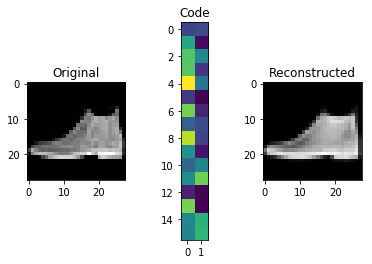

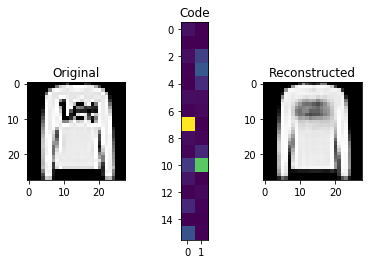

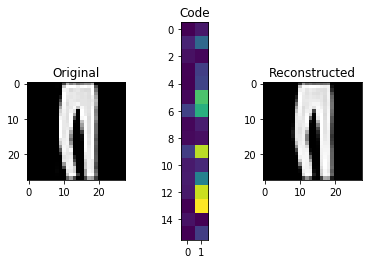

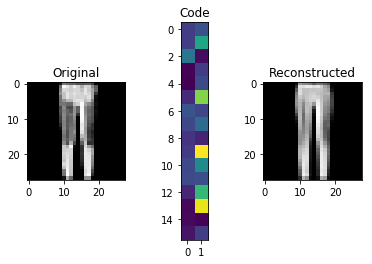

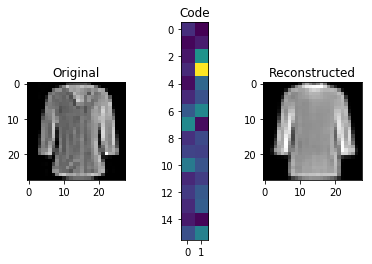

In [40]:
reconstruction_mse = autoencoder.evaluate(x_test, x_test, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)
for i in range(5):
    img = x_test[i]
    visualize(img,encoder,decoder)

In [ ]:
images = x_test
codes = encoder.predict(images)

In [ ]:
annoy_index = AnnoyIndex(bit_size, metric='angular')
for i in range(len(codes)):
    annoy_index.add_item(i, codes[i])

In [16]:
annoy_index.build(1000)

True

In [17]:
def get_similar_annoy(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    (images, distances) = annoy_index.get_nns_by_vector(vector=code[0], n=n_neighbors, include_distances=True, search_k=200000)
    
    return images, distances

In [18]:
def show_similar_annoy(image):
    neighbors, distances = get_similar_annoy(image,n_neighbors=5)
    
    plt.figure(figsize=[10,10])
    plt.subplot(1,6,1)
    show_image(image)
    plt.title("Original image")
    
    for i in range(5):
        plt.subplot(1,6,i+2)
        show_image(x_test[neighbors[i]])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [61]:
def get_accuracy(image_index, top_n=1):
    true_class = y_test[image_index]
    image = x_test[image_index]
    
    neighbors, distances = get_similar_annoy(image,n_neighbors=top_n)
    
    predict = []
    
    for neighbor in neighbors:
        predict.append(x_test[neighbor])
    
    scores = []
    
    for i in range(len(predict)):
        if i == 0:
            continue
        if y_test[neighbors[i]] == true_class:
            scores.append(1)
        else:
            scores.append(0)
    
    return np.mean(scores)

In [67]:
accuracies = []
for i in range(len(x_test)):
    accuracies.append(get_accuracy(i, top_n=11))

accuracy = np.mean(accuracies)
print(accuracy)

0.7609100000000001


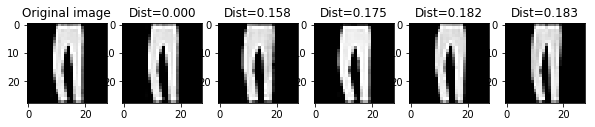

In [41]:
show_similar_annoy(x_test[2])

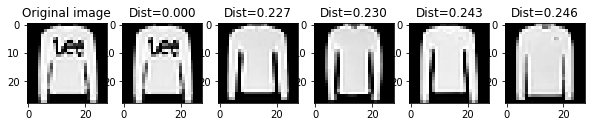

In [42]:
show_similar_annoy(x_test[1])

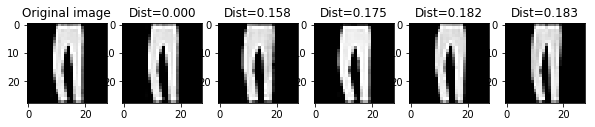

In [43]:
show_similar_annoy(x_test[2])

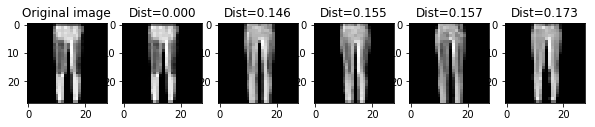

In [44]:
show_similar_annoy(x_test[3])

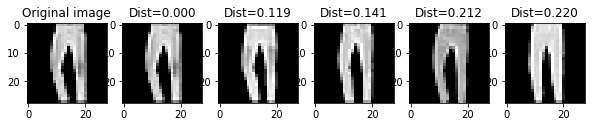

In [45]:
show_similar_annoy(x_test[5])

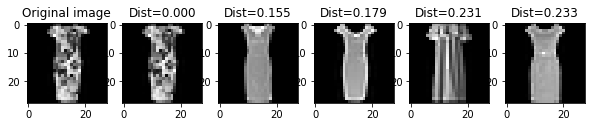

In [46]:
show_similar_annoy(x_test[100])

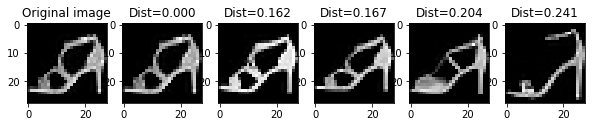

In [47]:
show_similar_annoy(x_test[82])

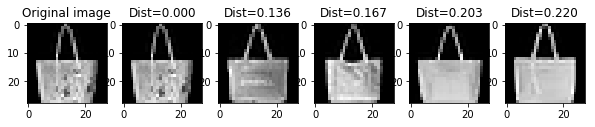

In [48]:
show_similar_annoy(x_test[256])

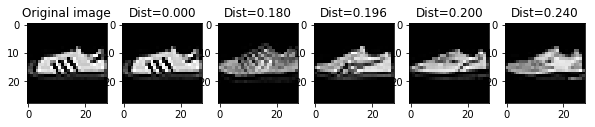

In [49]:
show_similar_annoy(x_test[308])

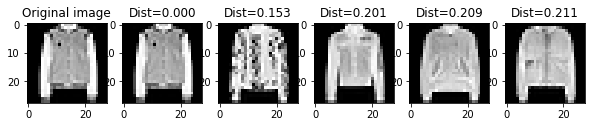

In [50]:
show_similar_annoy(x_test[4289])

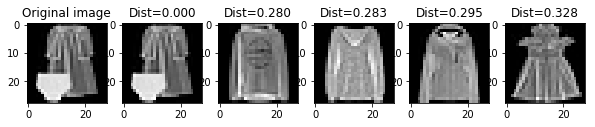

In [51]:
show_similar_annoy(x_test[5012])

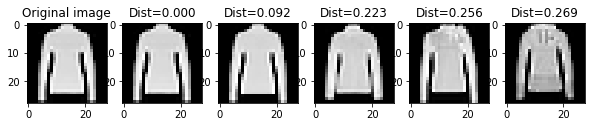

In [52]:
show_similar_annoy(x_test[8024])

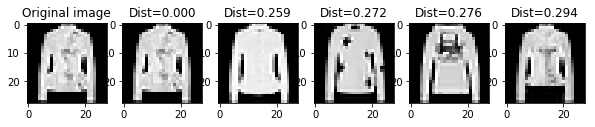

In [53]:
show_similar_annoy(x_test[3026])

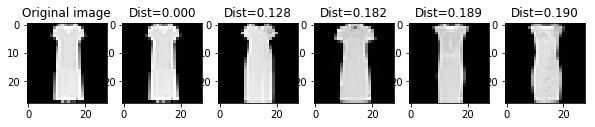

In [54]:
show_similar_annoy(x_test[1034])

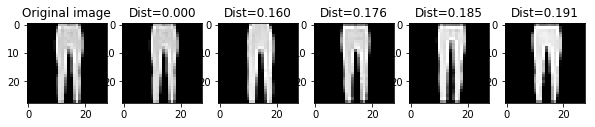

In [55]:
show_similar_annoy(x_test[9065])

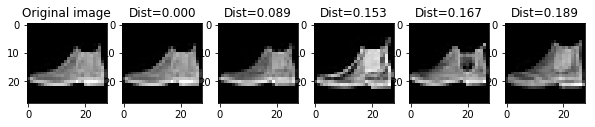

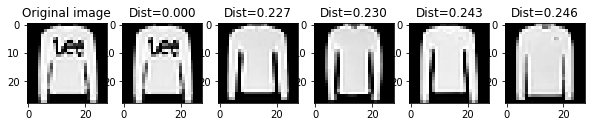

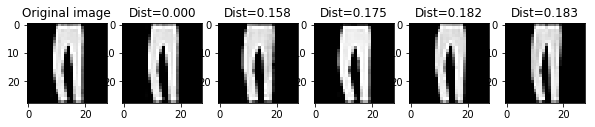

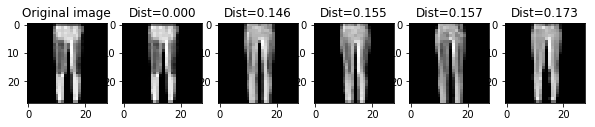

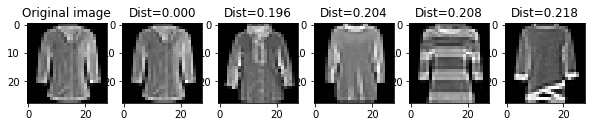

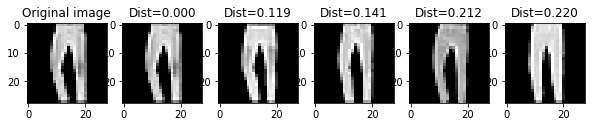

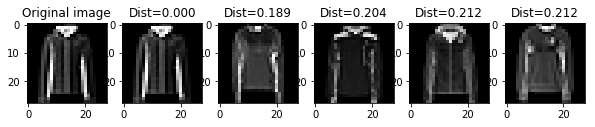

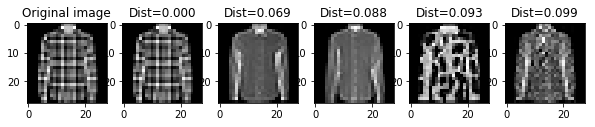

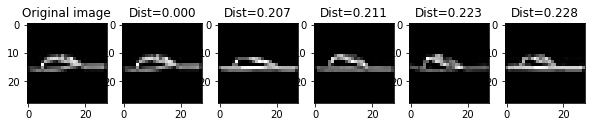

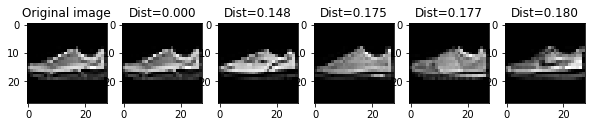

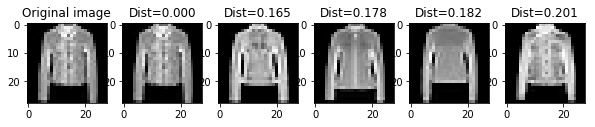

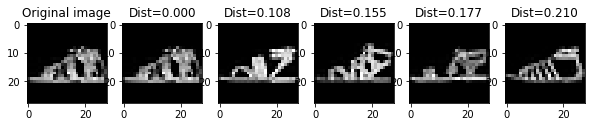

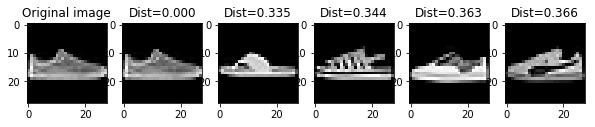

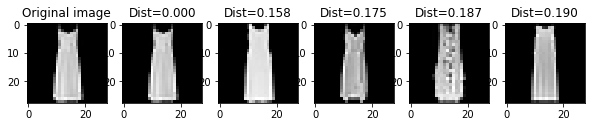

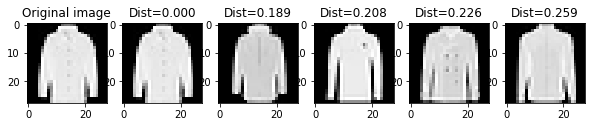

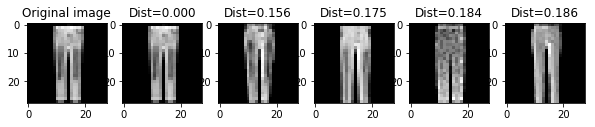

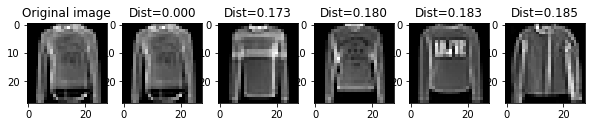

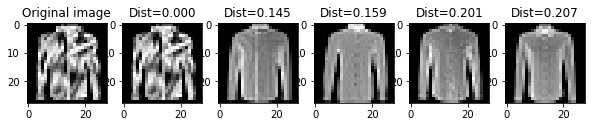

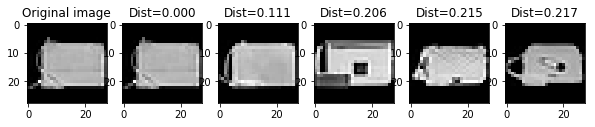

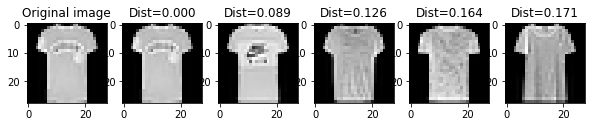

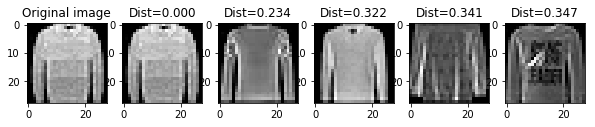

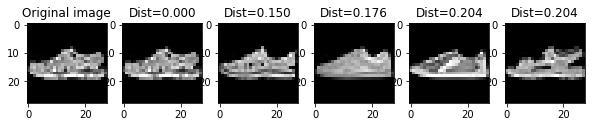

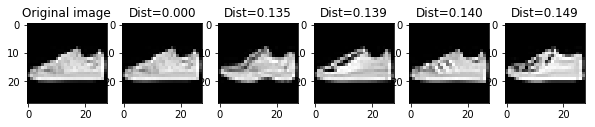

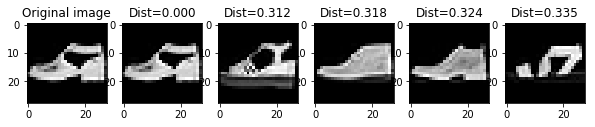

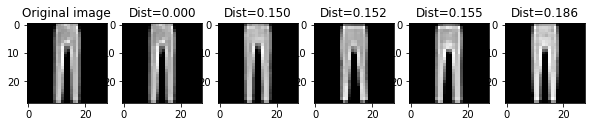

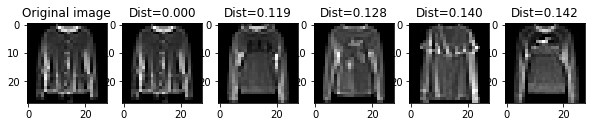

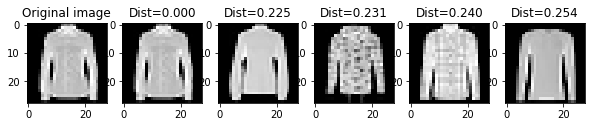

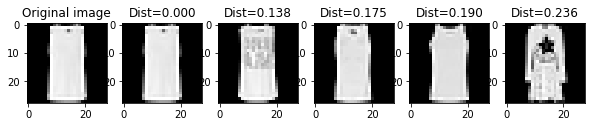

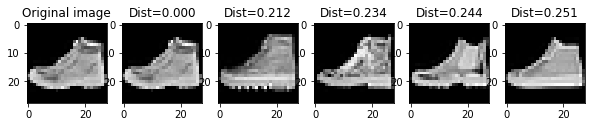

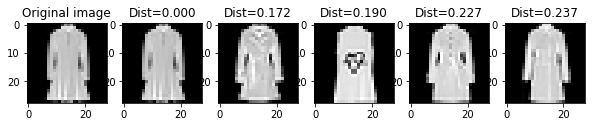

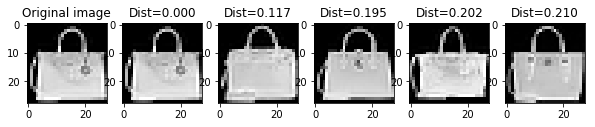

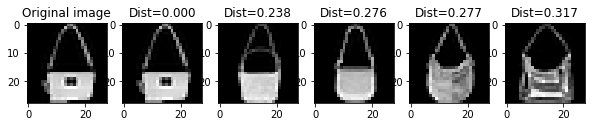

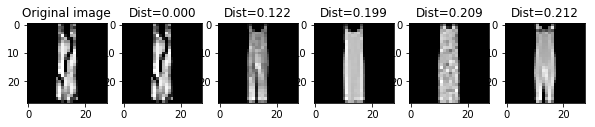

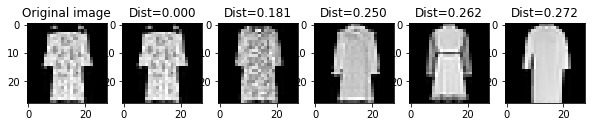

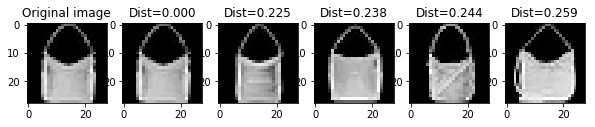

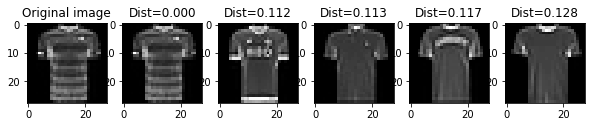

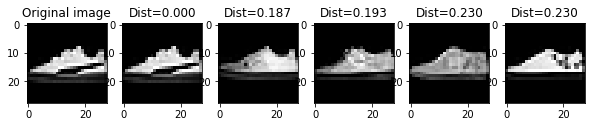

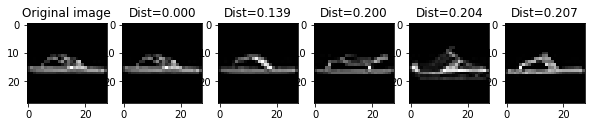

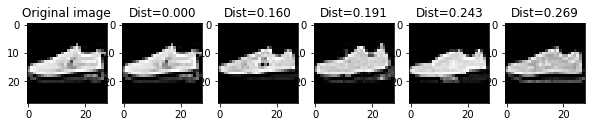

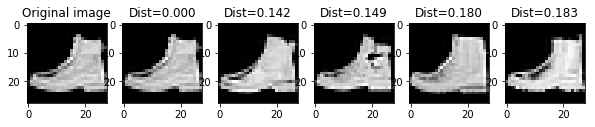

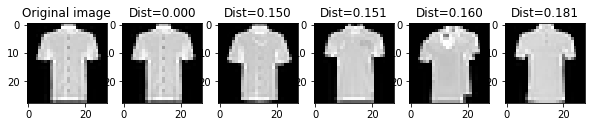

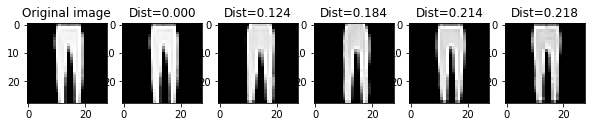

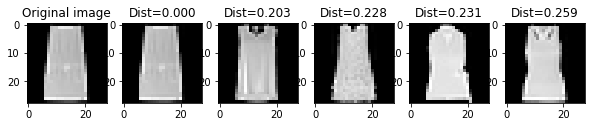

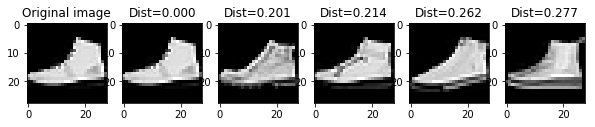

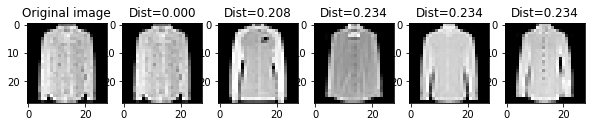

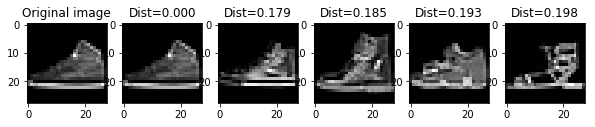

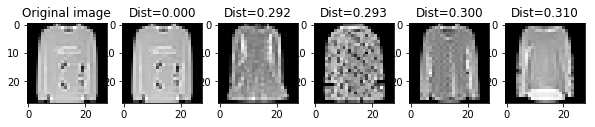

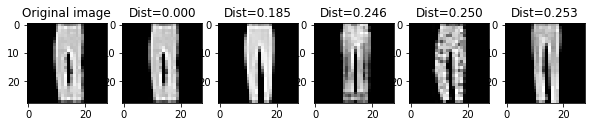

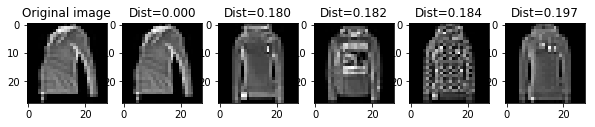

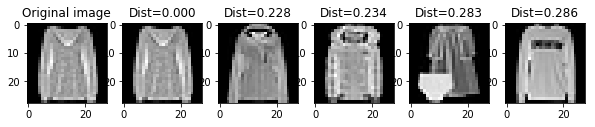

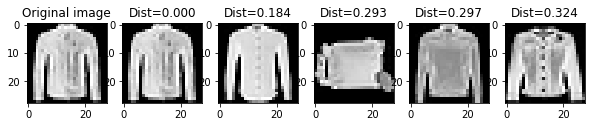

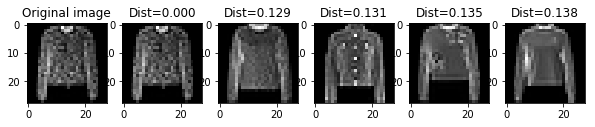

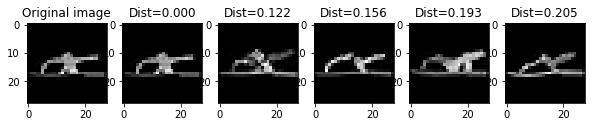

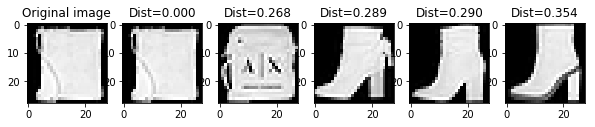

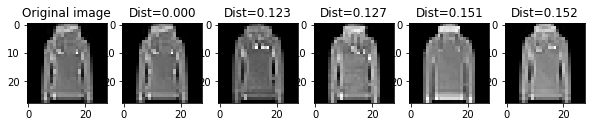

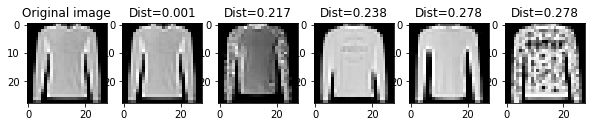

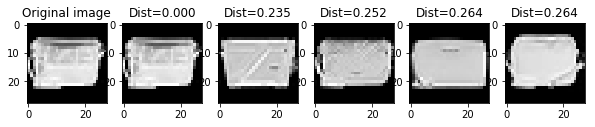

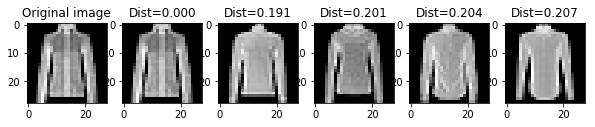

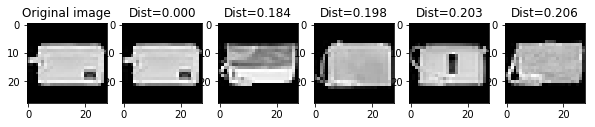

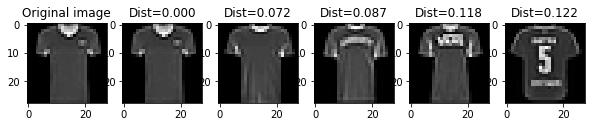

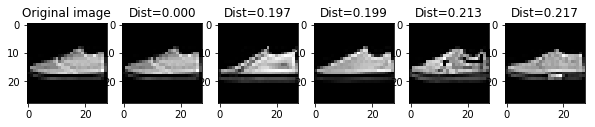

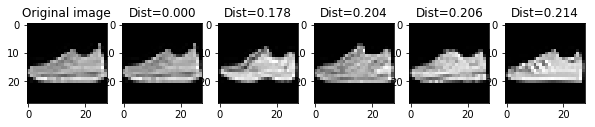

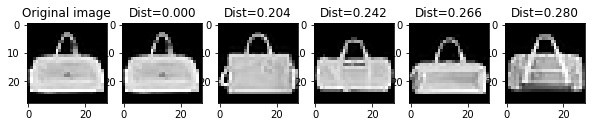

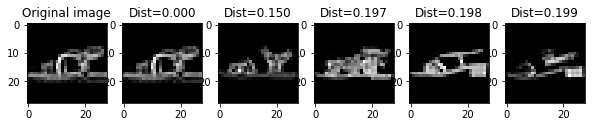

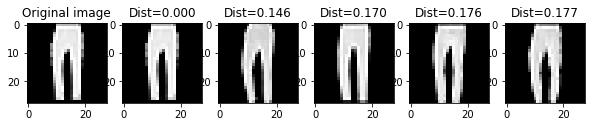

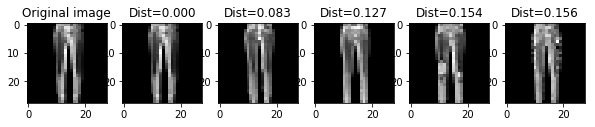

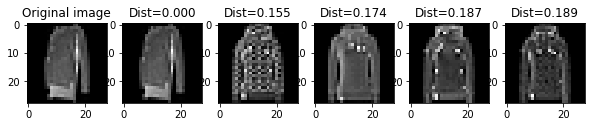

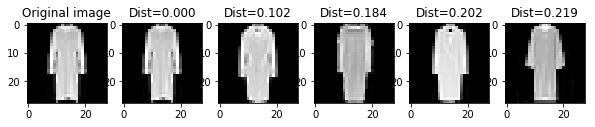

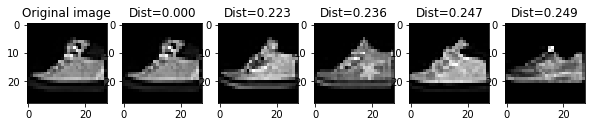

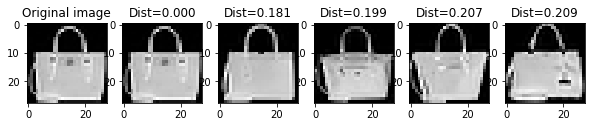

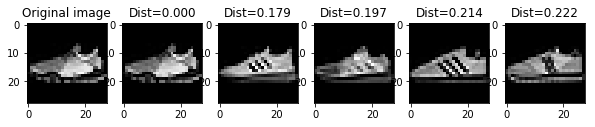

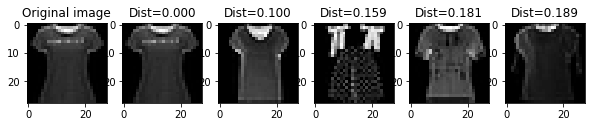

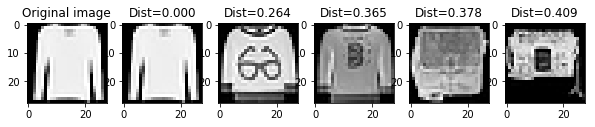

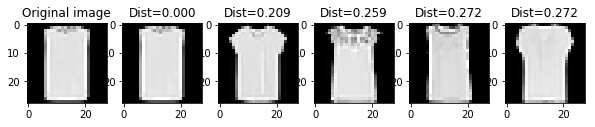

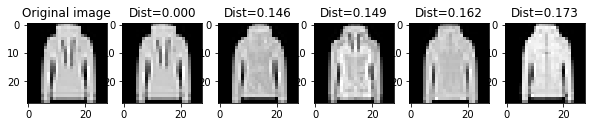

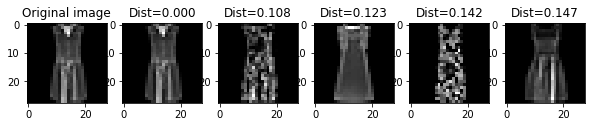

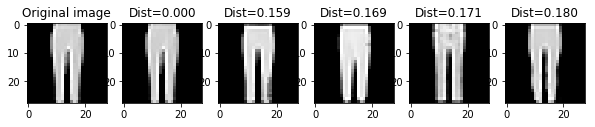

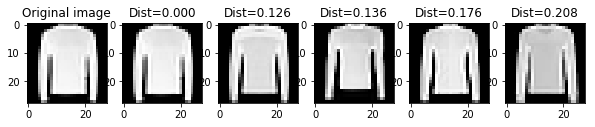

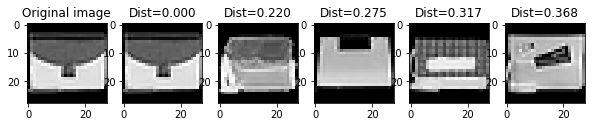

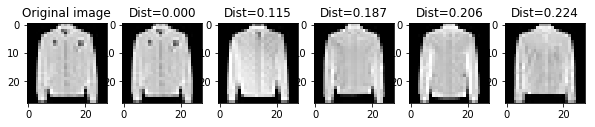

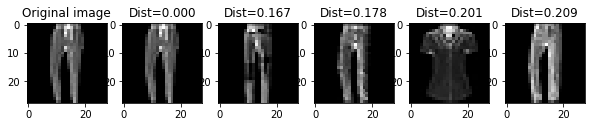

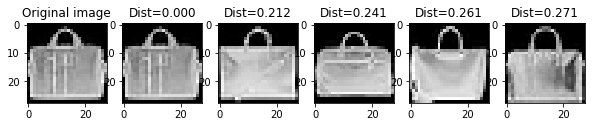

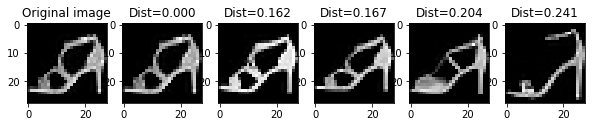

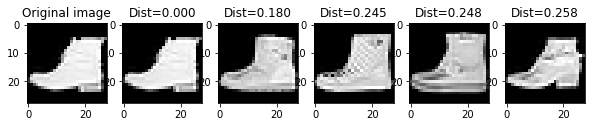

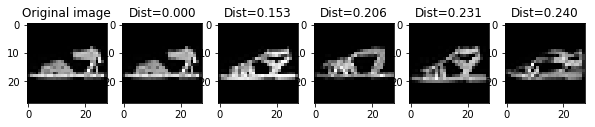

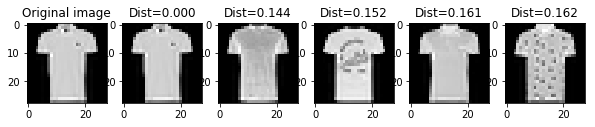

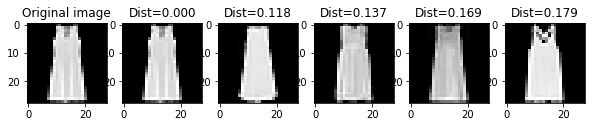

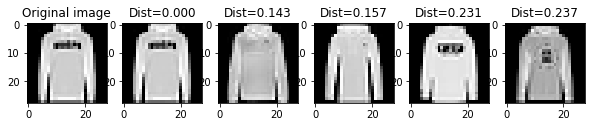

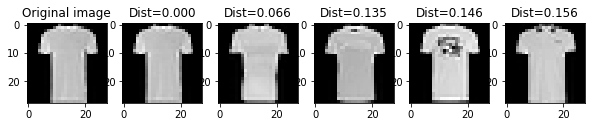

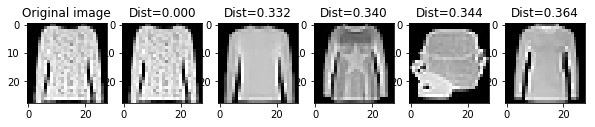

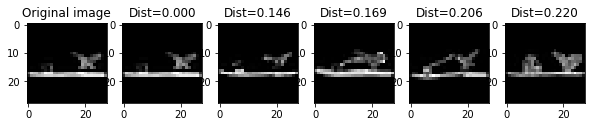

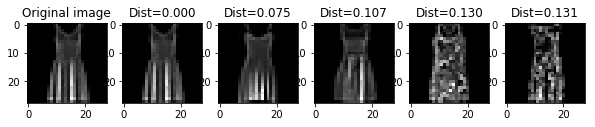

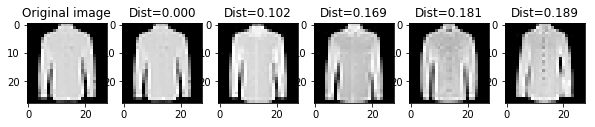

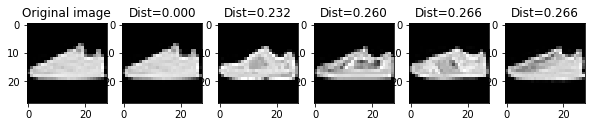

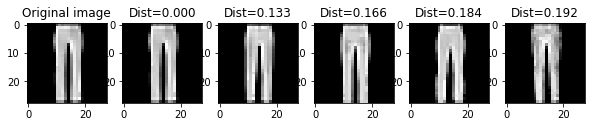

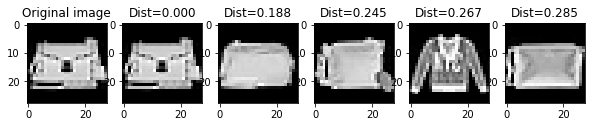

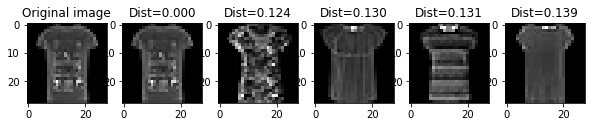

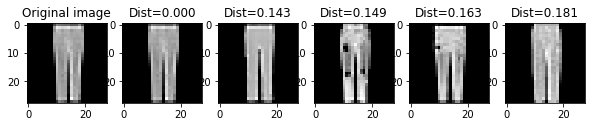

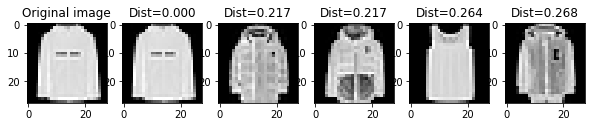

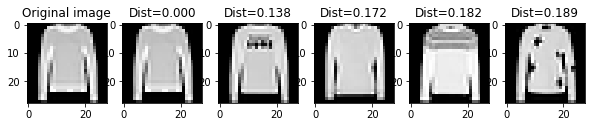

In [56]:
for i in range(100):
    show_similar_annoy(x_test[i])